In [2]:
import os
import matplotlib.pyplot as plt

from mlinspect.inspections.histogram_inspection import HistogramInspection
from mlinspect.checks.no_bias_introduced_for_constraint import NoBiasIntroducedForConstraint
from mlinspect.checks.no_illegal_features_constraint import NoIllegalFeaturesConstraint
from mlinspect.checks.check import Check
from demo.healthcare.no_missing_embeddings_constraint import NoMissingEmbeddingsConstraint
from mlinspect.inspections.lineage_inspection import LineageInspection
from mlinspect.inspections.materialize_first_rows_inspection import MaterializeFirstRowsInspection
from mlinspect.pipeline_inspector import PipelineInspector
from mlinspect.visualisation import save_fig_to_path
from mlinspect.utils import get_project_root
from mlinspect.instrumentation.dag_node import OperatorType
import pandas as pd
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# Overview of the example from the paper


![overview](paper_example_image.png)

 Example of an ML pipeline that predicts which patients are at a higher risk of serious complications, under the requirement to achieve comparable false negative rates across intersectional groups by age and race. The pipeline is implemented using native constructs from the popular pandas and scikit-learn libraries. On the left, we highlight potential issues identified by mlinspect. On the right, we show the corresponding dataflow graph extracted by mlinspect to instrument the code and pinpoint issues.

# Add inspections and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `healthcare.py` file, but e.g., `.ipynb` jupyter notebook files are already supported by mlinspect, too. Then, we define the set of inspections and checks we want mlinspect to run. In this example, we use 3 checks, one to compute histograms of sensitive groups and verify operators cause no significant distribution changes, one to check for missing embeddings of our word embeding transformer, and one to check for the usage of illegal/problematic features. We also use 2 additional inspections, one to track row-level lineage and one to materialize a few example output rows of each operator.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which contains both the extracted Dag, the output of our checks, and the output of our inspections. 

In [3]:
HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas.py")

check = Check()\
    .no_bias_introduced_for(['sex', 'race'])\

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_check(check) \
    .execute()

extracted_dag = inspector_result.dag
inspection_results = inspector_result.inspection_to_annotations
check_result = inspector_result.check_to_check_results[check]

0.8078521939953811


# Now, let's look at the extracted Dag

Mlinspect automatically extracted a dataflow graph corresponding to the code in the `healthcare.py` file. Now, we want to look at it. The format mlinspect returns the Dag in is a `networkx.DiGraph`. Networkx provides a lot of functionality, which makes it easy for users to e.g., convert it to other common formats. In addition to this, we also offer a visualisation function, `save_fig_to_path`, which can be directly used to save an image of the extracted Dag to some file path.

Here, we use that convenience function to save an image of the Dag and then use a jupyter notebook function to show this image. 

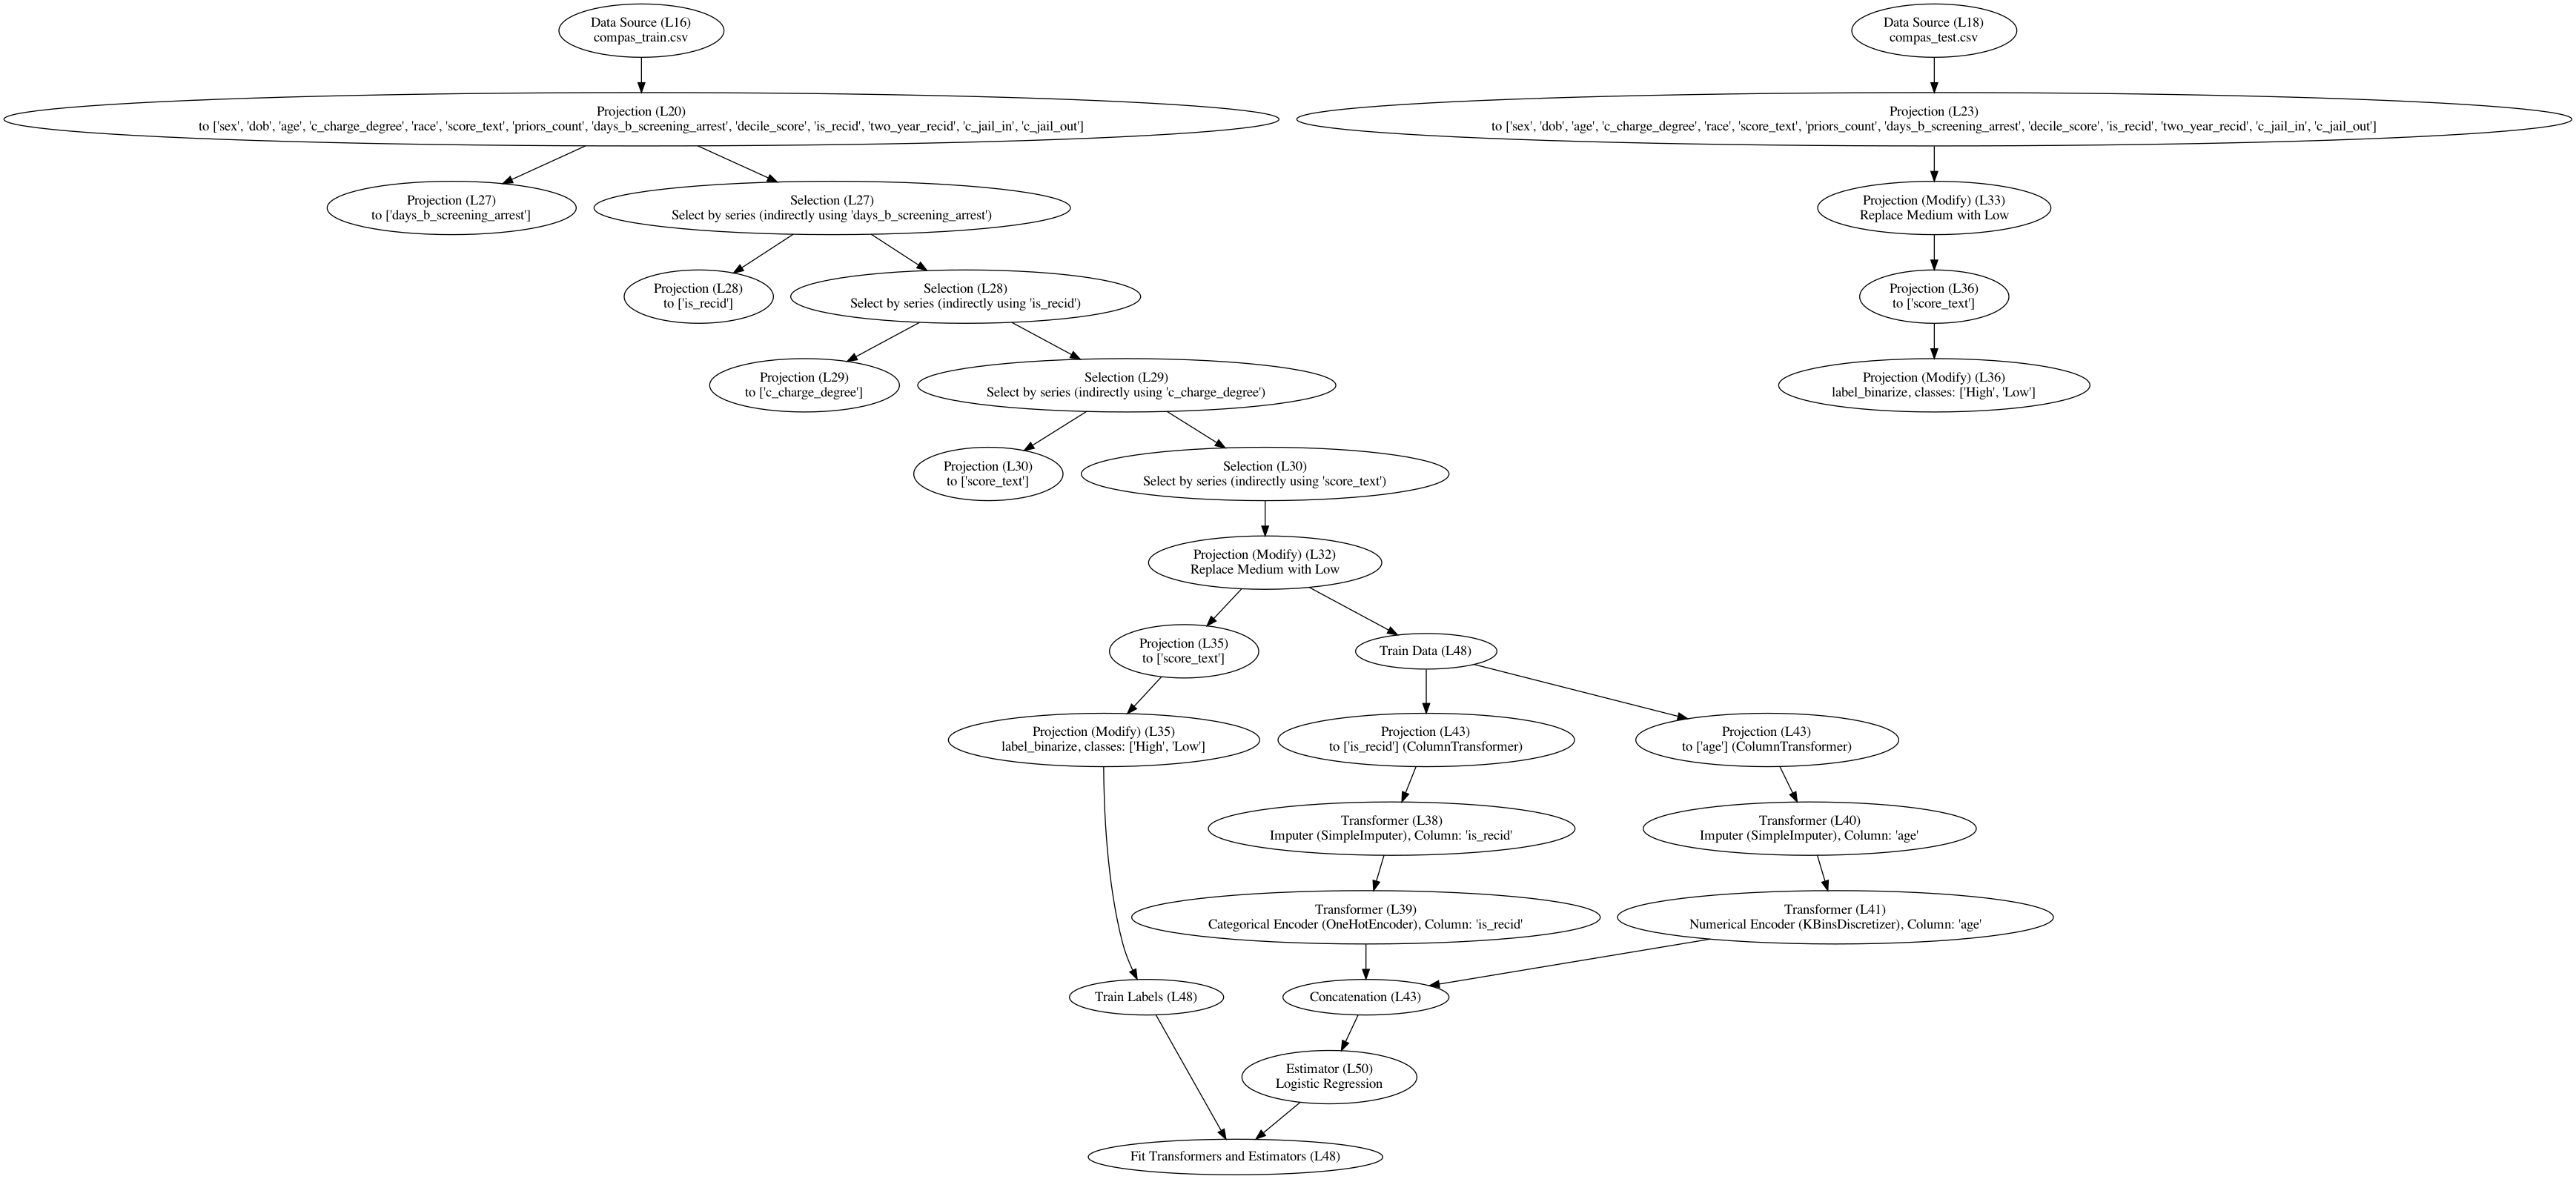

In [4]:
from IPython.display import Image

filename = os.path.join(str(get_project_root()), "example_pipelines", "compas", "compas.png")
save_fig_to_path(extracted_dag, filename)

Image(filename=filename) 

# Did our check find issues?

Let us look at the `check_result` to see whether some constraints failed. We see that some constraints failed and investigate which ones. As all 3 failed, we will look into each result in detail.

In [5]:
print(check_result.status)
print("")
for constraint_result in check_result.constraint_results.values():
    print("{}: {}".format(constraint_result.constraint, constraint_result.status))

CheckStatus.ERROR

NoBiasIntroducedForConstraint((('sex', 'race'), 0.3)): ConstraintStatus.FAILURE


# We can look at how histograms of sensitive groups change after different Dag nodes

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model. Mlinspect helps with identifying such issues by offering an inspection to calculate historams for sensitive groups. Thanks to our annotation propagation, this works even if the group columns are projected out at some point (**Issue 2**). To automatically check for significant changes and compute the histograms, we used the `no_bias_introduced_for(...)` constraint.

Our constraint has already filtered all operators that can cause data distribution issues. Now we will use the result of the constraint and create list with all distribution changes. Using this, we can investigate the changes of the different operators one at a time.

In [7]:
no_bias_introduced_result = check_result.constraint_results[NoBiasIntroducedForConstraint(['sex', 'race'])]

print("Dag nodes that could have changed the distribution:")
distribution_changes = []
for dag_node, distribution_change in no_bias_introduced_result.bias_distribution_change.items():
    print('\033[1m')
    print(dag_node.operator_type, dag_node.code_reference, dag_node.module, dag_node.description, '\033[0m')
    distribution_changes.append(distribution_change)
    for column, change_info in distribution_change.items():
        if not change_info.acceptable_change:
            print("The distribution of the sensitive column '{}' changed too much!".format(column))

Dag nodes that could have changed the distribution:

OperatorType.SELECTION CodeReference(lineno=27, col_offset=13, end_lineno=27, end_col_offset=119) ('pandas.core.frame', '__getitem__', 'Selection') Select by series (indirectly using 'days_b_screening_arrest') 
The distribution of the sensitive column 'race' changed too much!

OperatorType.SELECTION CodeReference(lineno=28, col_offset=13, end_lineno=28, end_col_offset=53) ('pandas.core.frame', '__getitem__', 'Selection') Select by series (indirectly using 'is_recid') 

OperatorType.SELECTION CodeReference(lineno=29, col_offset=13, end_lineno=29, end_col_offset=61) ('pandas.core.frame', '__getitem__', 'Selection') Select by series (indirectly using 'c_charge_degree') 

OperatorType.SELECTION CodeReference(lineno=30, col_offset=13, end_lineno=30, end_col_offset=58) ('pandas.core.frame', '__getitem__', 'Selection') Select by series (indirectly using 'score_text') 


As we can see, the selection causes the check to fail because of the `race` attribute. Still, we will investigate all of the operator changes to see if there is something else our check may have missed because the change was slightly below the change threshold of the `NoBiasIntroducedForConstraint(["age_group", "race"])` (which can be configured by the user).

Before we look at the impact of different operators on the data distribution, we start by defining a function to plot the histograms before and after selected operators.

In [8]:
def print_dag_operator_histograms(constraint_result, attribute):    
    print("{} histogram".format(attribute))
            
    plt.subplot(1, 2, 1)        
    before_output_race_group = constraint_result[attribute].before_map
    keys = [str(key) for key in before_output_race_group.keys()]
    plt.bar(keys, before_output_race_group.values())
    plt.gca().set_title("before")
   
    plt.subplot(1, 2, 2)
    after_output_race_group = constraint_result[attribute].after_map
    keys = [str(key) for key in after_output_race_group.keys()]
    plt.bar(keys, after_output_race_group.values())
    plt.gca().set_title("after")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.show()

## Issue 1: Join might change proportions of groups in data

We start by looking at the first operator that could heavily change the proportion of groups in our data, the join of the `patients` and `histories` datasets. E.g., there could be missing history entries for some patients, leading to many patients being filtered out.

Here, we start by finding the corresponding `JOIN` distribution change info for the `merge` call. Then we use the plot function we defined before to compare the histograms before and after this join.

{'sex': BiasDistributionChange(acceptable_change=True, max_relative_change=0.005297178559210659, before_map={'Male': 4079, 'Female': 970}, after_map={'Male': 3492, 'Female': 825}), 'race': BiasDistributionChange(acceptable_change=False, max_relative_change=0.4962863933452169, before_map={'Caucasian': 1707, 'African-American': 2588, 'Hispanic': 452, 'Native American': 14, 'Asian': 23, 'Other': 265}, after_map={'Caucasian': 1462, 'African-American': 2228, 'Hispanic': 357, 'Native American': 8, 'Asian': 22, 'Other': 240})}
race histogram


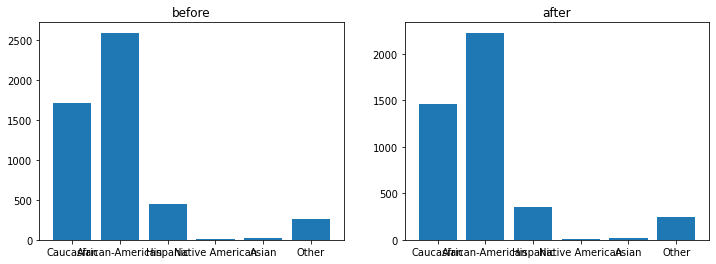

In [11]:
join = distribution_changes[0]
print(join)
print_dag_operator_histograms(join, "race")

**As we can see, there are no noteworthy changes because of the join.**

## Issue 3: Selection might change proportions of groups in data

The next operator that could change the data distribution is the filter for patients in a few predefined counties. It could be that patients of different demographic groups are not uniformly distributed across different counties. It could, e.g., be that most of the patients with a specific `age_group` or `race` value live in a specific county.

Again, we need to find the change info for the selection. Then, we look at the histograms before and after.

Age_group histogram


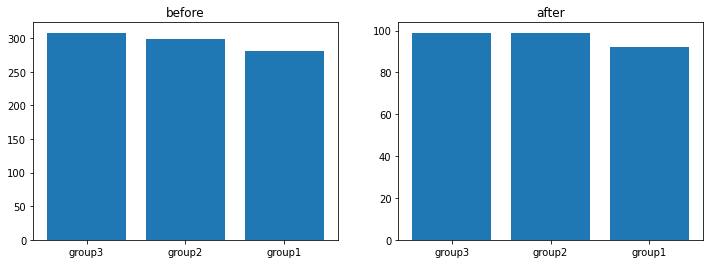

Race histogram


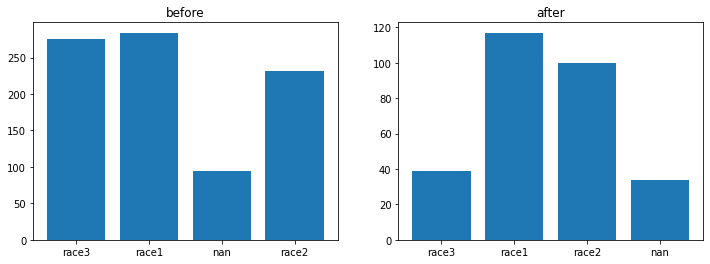

In [12]:
selection = distribution_changes[2]
print_dag_operator_histograms(selection)

**There clearly is an issue here! A lot of values from the `race` `race3` are filtered out!** This is because a lot of patients with `race3` live in `county1` in our example.

## Issue 4: Imputation might change proportions of groups in data

The last operator that we want to look at that can change the distribution of sensitive groups is the missing value imputation for the `race` column. Depending on the imputation strategy, it can also introduce or amplify data distribution issues. It might attribute records with a missing value to the majority race in the dataset.

Again, we need to find the change info for the imputation. Then, we look at the histograms before and after.

Age_group histogram


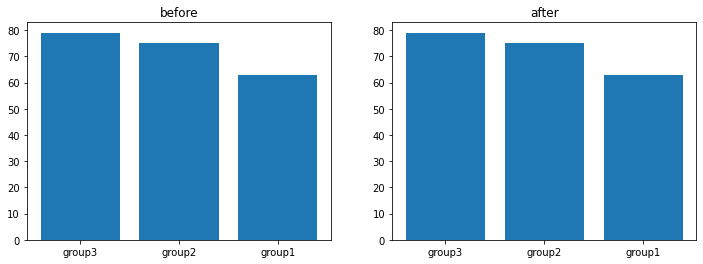

Race histogram


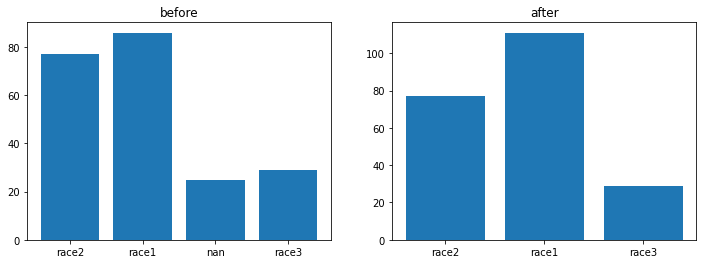

In [13]:
imputation = distribution_changes[3]
print_dag_operator_histograms(imputation)

**The `most-frequent` imputation amplifies the existing `race` imbalance!**